In [1]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import sqlite3
import os

In [2]:
# Test infos Aiven
user = "avnadmin"
host = "mysql-3e9f8491-thenuumfactory-934a.i.aivencloud.com"
port = 11249
database = "defaultdb"

# Lecture du mot de passe depuis un fichier texte local sécurisé
password_file = "secrets/aiven_password.txt"
if os.path.exists(password_file):
    with open(password_file, "r") as f:
        password = f.read().strip()
else:
    raise FileNotFoundError("Le fichier contenant le mot de passe Aiven est manquant.")


# Chemins vers les certificats
ssl_ca = './ca.pem'
# ssl_cert = "C:/certs/client-cert.pem"
# ssl_key = "C:/certs/client-key.pem"

# URL de connexion avec paramètres SSL
url = (
    f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}"
    f"?ssl_ca={ssl_ca}"
)

# Création du moteur SQLAlchemy
engine = create_engine(url)

In [3]:
df_orders = pd.read_sql("SELECT * FROM Orders", engine)
df_customers = pd.read_sql("SELECT * FROM Customers", engine)
df_products = pd.read_sql("SELECT * FROM Products", engine)
df_sellers = pd.read_sql("SELECT * FROM Sellers", engine)
df_meteo = pd.read_sql("SELECT * FROM Meteo", engine)

# Fusion (jointures)
df = df_orders \
    .merge(df_customers, left_on="Customer ID", right_on="CustomerID", how="left") \
    .merge(df_products, left_on="Product ID", right_on="ProductID", how="left") \
    .merge(df_sellers, left_on="Seller ID", right_on="SellerID", how="left") \
    .merge(df_meteo, left_on="Meteo ID", right_on="Meteo ID", how="left")

In [4]:
# Aperçu général
print("Dimensions du dataset :", df.shape)
print("\nTypes de données :\n", df.dtypes)
print("\nValeurs manquantes :\n", df.isnull().sum().sort_values(ascending=False).head(15))

Dimensions du dataset : (29142, 48)

Types de données :
 Unique ID                         object
Customer ID                       object
Product ID                        object
Seller ID                         object
Meteo ID                          object
Order Document Number             object
Order Line Number                  int64
Order Status                      object
Order Line Status                 object
Order Quantity                     int64
Order Price Amount               float64
Order Creation Date               object
Order Validated Date              object
Order Estimated Delivery Date     object
Order Shipping Delivery Date      object
Order Customer Delivery Date      object
Region                             int64
Payment Type                      object
is_Delayed                         int64
Order Delayed Cause               object
CustomerID                        object
CustomerName                      object
CustomerCity                      object


In [5]:
# Statistiques descriptives des variables numériques
display(df.describe())

,Order Line Number,Order Quantity,Order Price Amount,Region,is_Delayed,ProductPricelist,ProductLength,ProductWidth,ProductHeight,ProductWeight,NUM_POSTE,Niveau_intempérie
count,29142.000000,29142.000000,29142.000000,2.914200e+04,29142.000000,29142.000000,29142.000000,29142.000000,29142.000000,29142.000000,2.914200e+04,29142.000000
mean,200.621097,3.002848,184.873672,3.651979e+07,0.234095,61.740606,30.783851,33.881511,25.455528,2699.242537,3.651979e+07,1.112998
std,100.337230,1.411770,141.620470,2.344261e+07,0.423439,33.781985,16.071002,15.806326,12.432513,1414.251339,2.344261e+07,0.411849
min,100.000000,1.000000,3.610000,1.014002e+06,0.000000,3.610000,5.000000,5.000000,5.000000,140.000000,1.014002e+06,1.000000
25%,100.000000,2.000000,69.520000,1.304700e+07,0.000000,32.280000,16.000000,21.000000,15.000000,1486.000000,1.304700e+07,1.000000
50%,200.000000,3.000000,149.100000,3.241400e+07,0.000000,61.620000,30.000000,33.000000,25.000000,2811.000000,3.241400e+07,1.000000
75%,300.000000,4.000000,269.130000,5.960600e+07,0.000000,89.570000,44.000000,47.000000,36.000000,3898.000000,5.960600e+07,1.000000
max,400.000000,5.000000,597.600000,7.511601e+07,1.000000,119.520000,59.000000,59.000000,49.000000,4995.000000,7.511601e+07,5.000000


In [6]:
# Distribution des statuts de commande
print("\nRépartition des statuts de commande :\n", df["Order Status"].value_counts())
print("\nRépartition des statuts de livraison :\n", df["Order Line Status"].value_counts())


Répartition des statuts de commande :
 Order Status
partially delivered    27080
fully delivered         2062
Name: count, dtype: int64

Répartition des statuts de livraison :
 Order Line Status
delivered        9798
not validated    9677
validated        9667
Name: count, dtype: int64


In [7]:
# Colonnes temporelles : vérification
print("\nAperçu des dates de livraison et de validation :")
print(df[["Order Validated Date", "Order Shipping Delivery Date"]].head())



Aperçu des dates de livraison et de validation :
  Order Validated Date Order Shipping Delivery Date
0           02/09/2024                   07/09/2024
1           01/09/2024                   05/09/2024
2           30/09/2024                   03/10/2024
3           29/09/2024                   04/10/2024
4           03/10/2024                   13/10/2024


C:\Users\alexi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


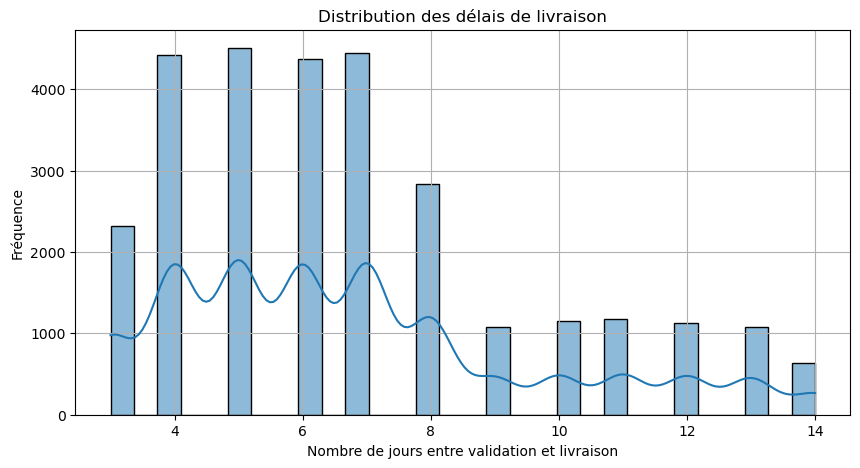

In [8]:
# Création d'une variable de retard si possible

df["Order Validated Date"] = pd.to_datetime(df["Order Validated Date"],format="%d/%m/%Y", errors='coerce')
df["Order Shipping Delivery Date"] = pd.to_datetime(df["Order Shipping Delivery Date"],format="%d/%m/%Y", errors='coerce')
df["Delivery_Delay"] = (df["Order Shipping Delivery Date"] - df["Order Validated Date"]).dt.days
df["IsLate"] = df["Delivery_Delay"] > 7

# Visualisation des délais de livraison
plt.figure(figsize=(10, 5))
sns.histplot(df["Delivery_Delay"].dropna(), bins=30, kde=True)
plt.title("Distribution des délais de livraison")
plt.xlabel("Nombre de jours entre validation et livraison")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()


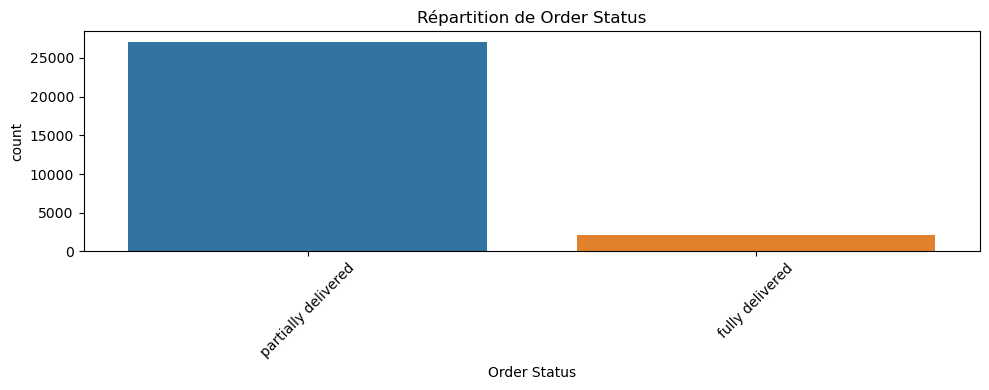

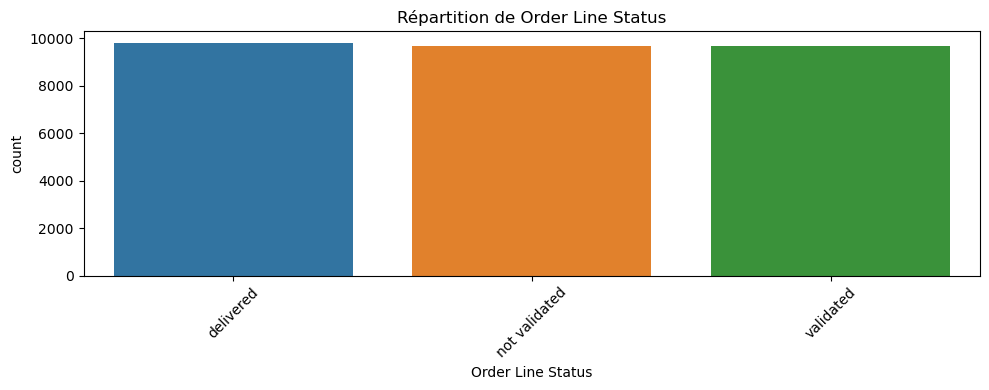

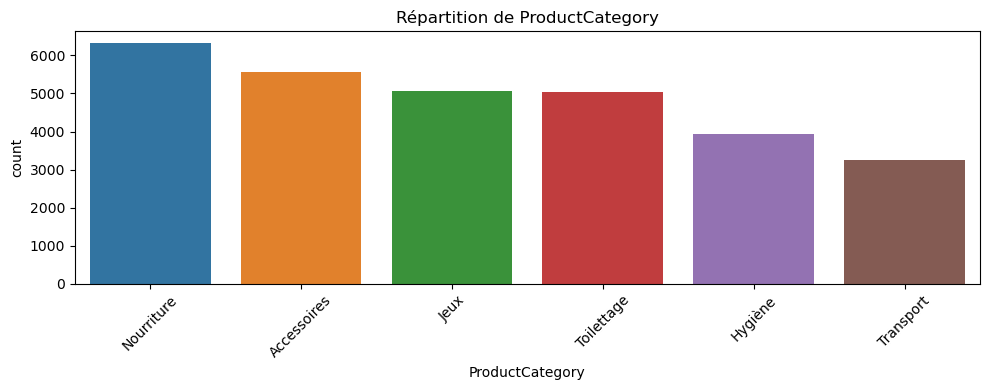

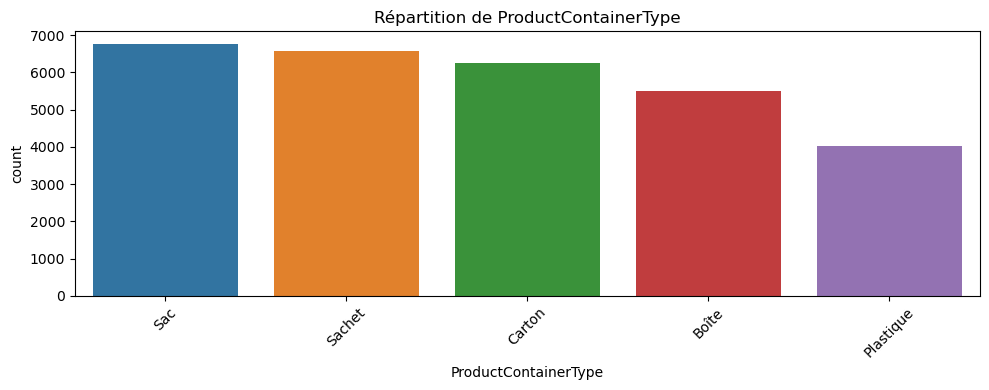

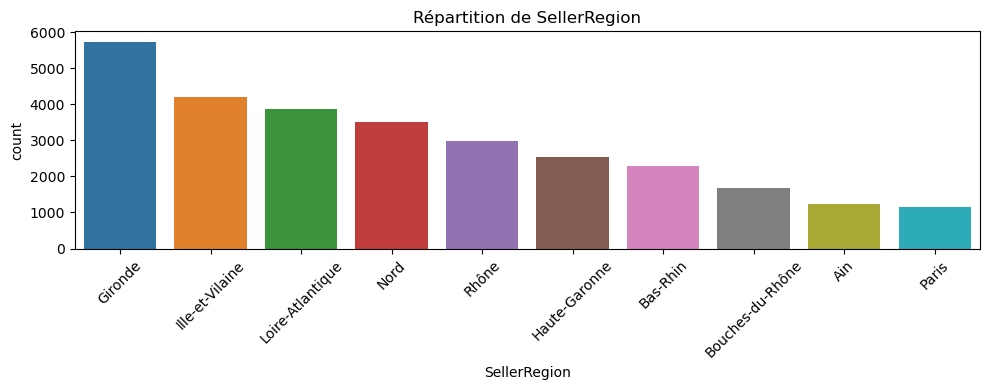

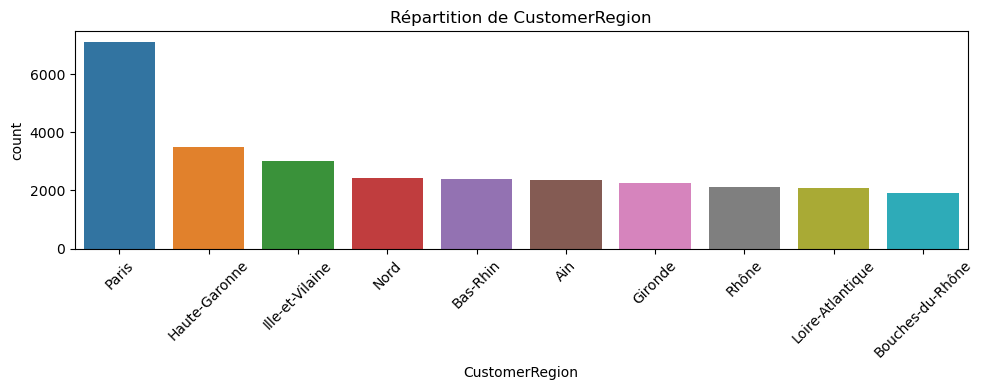

In [9]:
# Variables catégorielles clés
cat_cols = ["Order Status", "Order Line Status", "ProductCategory", "ProductContainerType", "SellerRegion", "CustomerRegion"]
for col in cat_cols:
    if col in df.columns:
        plt.figure(figsize=(10, 4))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f"Répartition de {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


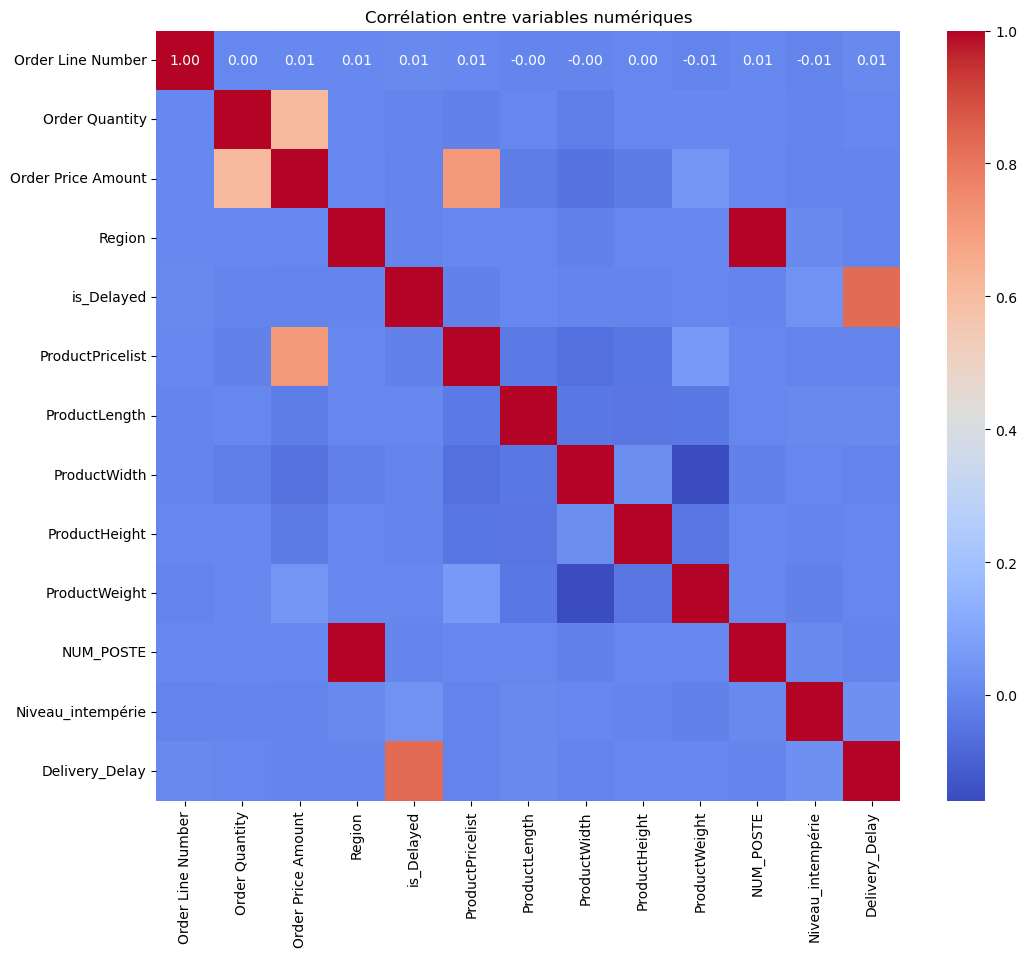

In [10]:
# Corrélations numériques
num_cols = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 10))
sns.heatmap(num_cols.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Corrélation entre variables numériques")
plt.show()


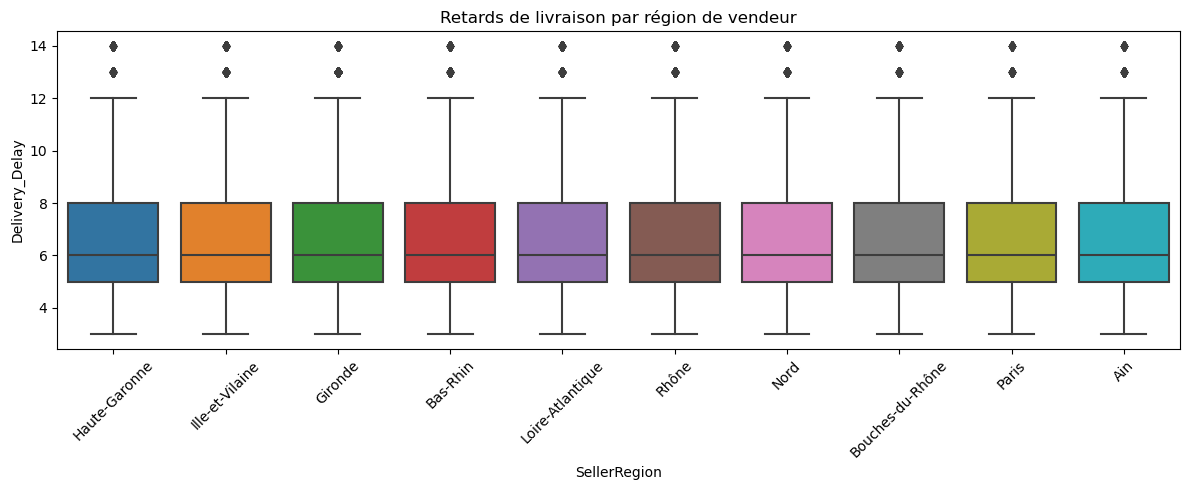

In [11]:
# Analyse des retards par région, météo ou catégorie produit
if "SellerRegion" in df.columns:
    plt.figure(figsize=(12, 5))
    sns.boxplot(x="SellerRegion", y="Delivery_Delay", data=df)
    plt.xticks(rotation=45)
    plt.title("Retards de livraison par région de vendeur")
    plt.tight_layout()
    plt.show()

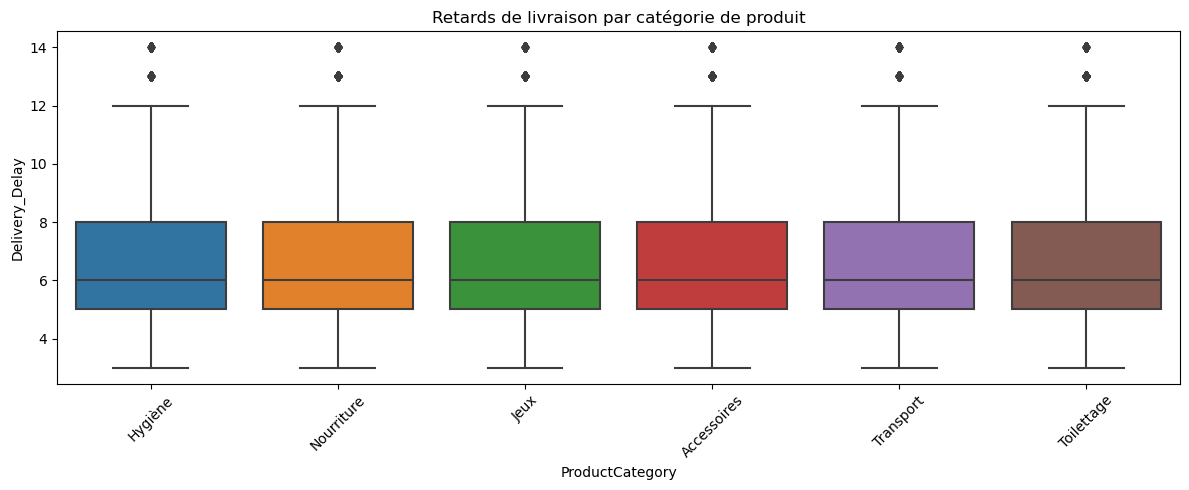

In [12]:
if "ProductCategory" in df.columns:
    plt.figure(figsize=(12, 5))
    sns.boxplot(x="ProductCategory", y="Delivery_Delay", data=df)
    plt.xticks(rotation=45)
    plt.title("Retards de livraison par catégorie de produit")
    plt.tight_layout()
    plt.show()

# Sauvegarde du dataset enrichi si besoin
# df.to_csv("df_with_delay.csv", index=False)


In [13]:
df.describe

<bound method NDFrame.describe of          Unique ID Customer ID Product ID Seller ID        Meteo ID  \
0      O000001-100      C00044     P00185     S0011  45542-44129001   
1      O000001-200      C00044     P00105     S0011  45540-31454001   
2      O000002-100      C00208     P00079     S0029   45568-1072001   
3      O000002-200      C00208     P00170     S0029  45569-69203001   
4      O000003-100      C00129     P00031     S0066  45578-69029001   
...            ...         ...        ...       ...             ...   
29137  O011948-400      C00348     P00065     S0098  45302-31374001   
29138  O011949-100      C00305     P00174     S0043  45477-59392001   
29139  O011949-200      C00405     P00052     S0094  45579-44184001   
29140  O011950-100      C00405     P00072     S0094  45578-13001009   
29141  O011951-100      C00405     P00107     S0094  45578-32035001   

      Order Document Number  Order Line Number         Order Status  \
0                   O000001               

In [14]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [15]:
# Copie du DataFrame pour éviter d'écraser l'original
df_cleaned = df.copy()

In [16]:
# Traitement des dates
df_cleaned["Order Validated Date"] = pd.to_datetime(df_cleaned["Order Validated Date"], errors='coerce')
df_cleaned["Order Shipping Delivery Date"] = pd.to_datetime(df_cleaned["Order Shipping Delivery Date"], errors='coerce')
df_cleaned["Delivery_Delay"] = (df_cleaned["Order Shipping Delivery Date"] - df_cleaned["Order Validated Date"]).dt.days
df_cleaned["IsLate"] = df_cleaned["Delivery_Delay"] > 2

In [17]:
# Extraction de nouvelles variables temporelles
df_cleaned["OrderMonth"] = df_cleaned["Order Validated Date"].dt.month
df_cleaned["OrderWeekday"] = df_cleaned["Order Validated Date"].dt.weekday
df_cleaned["OrderYear"] = df_cleaned["Order Validated Date"].dt.year

In [18]:
# Remplissage des valeurs manquantes simples
df_cleaned["ProductWeight"].fillna(df_cleaned["ProductWeight"].median(), inplace=True)
df_cleaned["ProductHeight"].fillna(df_cleaned["ProductHeight"].median(), inplace=True)
df_cleaned["ProductWidth"].fillna(df_cleaned["ProductWidth"].median(), inplace=True)
df_cleaned["ProductLength"].fillna(df_cleaned["ProductLength"].median(), inplace=True)
df_cleaned["Niveau_intempérie"].fillna("Non renseigné", inplace=True)

In [19]:
# Encodage binaire de la météo : présence d'intempérie ou non
df_cleaned["HasWeatherIssue"] = df_cleaned["Niveau_intempérie"].apply(lambda x: 0 if x == "Non renseigné" else 1)

In [20]:
# Encodage des colonnes catégorielles : Label Encoding (rapide), à remplacer par OneHot si besoin
cat_cols = ["Order Status", "Order Line Status", "ProductCategory", "ProductContainerType",
            "SellerRegion", "CustomerRegion", "Niveau_intempérie"]

for col in cat_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].astype("category").cat.codes

In [21]:
# Suppression des colonnes inutiles pour le modèle
cols_to_drop = ["Unique ID", "Order Document Number", "Order Line Number", "Customer ID", "Product ID", 
                "Seller ID", "Meteo ID", "Date", "NOM_USUEL", "NUM_POSTE", "Facteur_intempérie"]
df_cleaned.drop(columns=[col for col in cols_to_drop if col in df_cleaned.columns], inplace=True)

In [22]:
# Supprimer les lignes avec valeurs critiques manquantes
df_cleaned.dropna(subset=["Order Validated Date", "Order Shipping Delivery Date", "Delivery_Delay"], inplace=True)

In [23]:
# Filtrage de valeurs aberrantes de délai
df_cleaned = df_cleaned[(df_cleaned["Delivery_Delay"] > -1) & (df_cleaned["Delivery_Delay"] < 60)]

In [24]:
# Aperçu final du dataset nettoyé
print("Dimensions du dataset nettoyé :", df_cleaned.shape)
display(df_cleaned.head())

Dimensions du dataset nettoyé : (29142, 43)


,Order Status,Order Line Status,Order Quantity,Order Price Amount,Order Creation Date,Order Validated Date,Order Estimated Delivery Date,Order Shipping Delivery Date,Order Customer Delivery Date,Region,...,SellerZipCode,SellerRegion,SellerCommune,Niveau_intempérie,Delivery_Delay,IsLate,OrderMonth,OrderWeekday,OrderYear,HasWeatherIssue
0,1,2,1,32.68,31/08/2024,2024-09-02,06/09/2024,2024-09-07,07/09/2024,44129001,...,44000,4,None,0,5,True,9,0,2024,1
1,1,1,3,144.27,31/08/2024,2024-09-01,06/09/2024,2024-09-05,05/09/2024,31454001,...,44000,4,None,0,4,True,9,6,2024,1
2,1,2,3,336.63,28/09/2024,2024-09-30,03/10/2024,2024-10-03,03/10/2024,1072001,...,59000,5,None,0,3,True,9,0,2024,1
3,1,2,3,90.87,28/09/2024,2024-09-29,04/10/2024,2024-10-04,05/10/2024,69203001,...,59000,5,None,0,5,True,9,6,2024,1
4,0,0,4,204.52,01/10/2024,2024-10-03,06/10/2024,2024-10-13,14/10/2024,69029001,...,44000,5,None,0,10,True,10,3,2024,1


In [25]:

# --- Étape 4 : Construction des pipelines de traitement ---
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import pickle 

In [26]:
# Définition de la cible
target = "is_Delayed"

# Séparation X / y
cols_to_exclude = ["Order Shipping Delivery Date","Order Customer Delivery Date", "Delivery_Delay"]  # colonnes futures non utilisables
X = df_cleaned.drop(columns=[target] +cols_to_exclude)
y = df_cleaned[target].astype(int)

In [27]:
# Identification des colonnes numériques et catégorielles
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Imputation et scaling pour les numériques
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Imputation et encodage pour les catégorielles
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [28]:
# Construction du préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Pipeline complet (exemple avec RandomForest à intégrer plus tard)
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor)
])


In [29]:
#Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Entraînement du préprocesseur pour inspection
pipeline.fit(X_train)

#Transformation des données (juste pour test)
X_train_transformed = pipeline.transform(X_train)
X_test_transformed = pipeline.transform(X_test)

print("Pipeline appliqué avec succès.")
print("Forme de X_train transformé :", X_train_transformed.shape)

#Sauvegarde du pipeline de prétraitement avec pickle
with open("preprocessing_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

Pipeline appliqué avec succès.
Forme de X_train transformé : (23313, 2337)


In [30]:
!pip install xgboost

In [31]:
# --- Étape 5 : Entraînement des modèles de base ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [32]:
# Fonction d'entraînement et d'évaluation
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\nModèle : {model.__class__.__name__}")
    print("Accuracy :", accuracy_score(y_test, preds))
    print("F1 Score :", f1_score(y_test, preds))
    print("\nMatrice de confusion :\n", confusion_matrix(y_test, preds))
    print("\nRapport de classification :\n", classification_report(y_test, preds))

# Modèles de base à tester
models = [
    LogisticRegression(max_iter=1000),
    RandomForestClassifier(random_state=42),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss')
]

In [33]:
for model in models:
    full_pipeline = Pipeline(steps=[
        ("preprocessor", pipeline.named_steps["preprocessor"]),
        ("classifier", model)
    ])
    evaluate_model(full_pipeline, X_train, y_train, X_test, y_test)


Modèle : Pipeline
Accuracy : 0.8476582604220277
F1 Score : 0.5379812695109261

Matrice de confusion :
 [[4424   40]
 [ 848  517]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.84      0.99      0.91      4464
           1       0.93      0.38      0.54      1365

    accuracy                           0.85      5829
   macro avg       0.88      0.68      0.72      5829
weighted avg       0.86      0.85      0.82      5829


Modèle : Pipeline
Accuracy : 0.8505747126436781
F1 Score : 0.5364555614688664

Matrice de confusion :
 [[4454   10]
 [ 861  504]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.84      1.00      0.91      4464
           1       0.98      0.37      0.54      1365

    accuracy                           0.85      5829
   macro avg       0.91      0.68      0.72      5829
weighted avg       0.87      0.85      0.82      5829


Modèle : Pipeline
Accur

In [34]:

# --- Étape 6 : Fine-tuning avec GridSearchCV ---
# Pipeline complet avec modèle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Exemple sur RandomForestClassifier
param_grid = {
    "classifier__n_estimators": [50, 100],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5],
}


tuned_pipeline = Pipeline(steps=[
    ("preprocessor", pipeline.named_steps["preprocessor"]),
    ("classifier", RandomForestClassifier(random_state=42))
])

In [35]:
# Recherche par validation croisée
grid_search = GridSearchCV(
    estimator=tuned_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring="f1",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Meilleurs paramètres :")
print(grid_search.best_params_)

print("\nMeilleur score F1 (validation croisée) :")
print(grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Meilleurs paramètres :
{'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}

Meilleur score F1 (validation croisée) :
0.5172878864833153


In [36]:
# Évaluer sur le jeu de test
from sklearn.metrics import classification_report, confusion_matrix

y_pred = grid_search.predict(X_test)

print("\nÉvaluation sur le jeu de test :")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



Évaluation sur le jeu de test :
[[4451   13]
 [ 860  505]]
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      4464
           1       0.97      0.37      0.54      1365

    accuracy                           0.85      5829
   macro avg       0.91      0.68      0.72      5829
weighted avg       0.87      0.85      0.82      5829



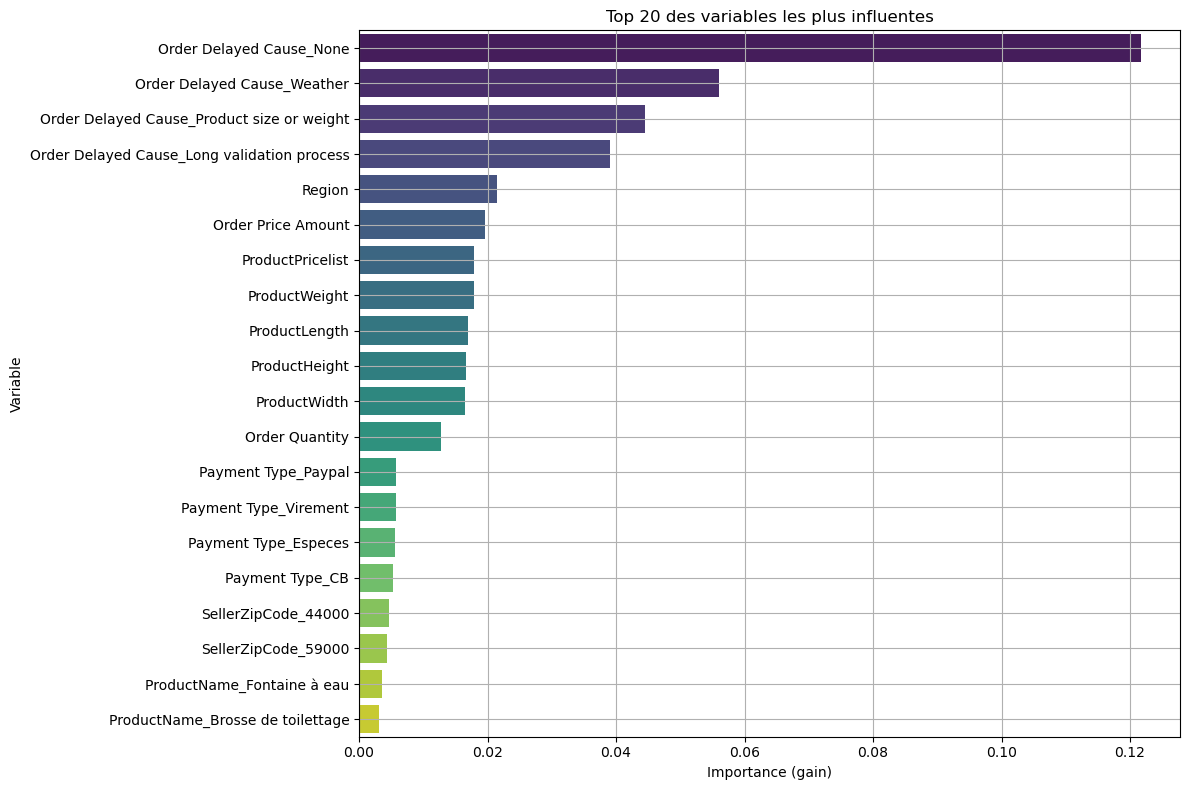


Top 10 des variables les plus importantes :
                                    Feature  Importance
                   Order Delayed Cause_None    0.121697
                Order Delayed Cause_Weather    0.056077
 Order Delayed Cause_Product size or weight    0.044547
Order Delayed Cause_Long validation process    0.039010
                                     Region    0.021471
                         Order Price Amount    0.019579
                           ProductPricelist    0.017966
                              ProductWeight    0.017899
                              ProductLength    0.016907
                              ProductHeight    0.016628


In [37]:
# --- Étape 7 : Analyse approfondie de l'importance des variables (Feature Importance) ---

# Vérifier le type du meilleur modèle
best_model = grid_search.best_estimator_.named_steps["classifier"]

if hasattr(best_model, "feature_importances_"):
    # Récupérer le preprocessor
    preprocessor = grid_search.best_estimator_.named_steps["preprocessor"]

    # Colonnes numériques
    numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

    # Colonnes catégorielles
    categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

    # Récupération des noms après transformation
    cat_encoder = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)

    # Concaténer les noms de toutes les features dans le même ordre que le modèle les voit
    all_feature_names = np.concatenate([numeric_features, cat_feature_names])

    # Extraire les importances
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        "Feature": all_feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    # Affichage des 20 plus importantes
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance_df.head(20), y="Feature", x="Importance", palette="viridis")
    plt.title("Top 20 des variables les plus influentes")
    plt.xlabel("Importance (gain)")
    plt.ylabel("Variable")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Affichage texte des 10 variables les plus influentes
    print("\nTop 10 des variables les plus importantes :")
    print(feature_importance_df.head(10).to_string(index=False))
else:
    print("Le modèle sélectionné ne permet pas l'extraction directe des importances des variables.")


In [38]:

# --- Étape 8 : Re-traitement pour améliorer les performances du modèle ---
from sklearn.feature_selection import SelectFromModel

# 1. Réduction automatique de features peu utiles
# Seuil : 90e percentile des importances
importance_threshold = np.percentile(feature_importance_df["Importance"], 90)
print(f"Seuil d'importance retenu : {importance_threshold:.4f}")

# Sélectionneur de features
selector = SelectFromModel(best_model, threshold=importance_threshold, prefit=True)

# Application au train/test
X_train_reduced = selector.transform(pipeline.named_steps["preprocessor"].transform(X_train))
X_test_reduced = selector.transform(pipeline.named_steps["preprocessor"].transform(X_test))

print("Nouvelle forme des données réduites :", X_train_reduced.shape)

# 2. Réentraînement d'un modèle simplifié
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

model_reduced = RandomForestClassifier(random_state=42)
model_reduced.fit(X_train_reduced, y_train)

y_pred_reduced = model_reduced.predict(X_test_reduced)

# 3. Évaluation du nouveau modèle
print("\n--- Évaluation du modèle simplifié ---")
print("F1 Score :", f1_score(y_test, y_pred_reduced))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_reduced))
print("Rapport de classification :\n", classification_report(y_test, y_pred_reduced))

Seuil d'importance retenu : 0.0004
Nouvelle forme des données réduites : (23313, 234)

--- Évaluation du modèle simplifié ---
F1 Score : 0.5338305807139051
Matrice de confusion :
 [[4453   11]
 [ 864  501]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.84      1.00      0.91      4464
           1       0.98      0.37      0.53      1365

    accuracy                           0.85      5829
   macro avg       0.91      0.68      0.72      5829
weighted avg       0.87      0.85      0.82      5829



100%|===================| 599/600 [00:58<00:00]        

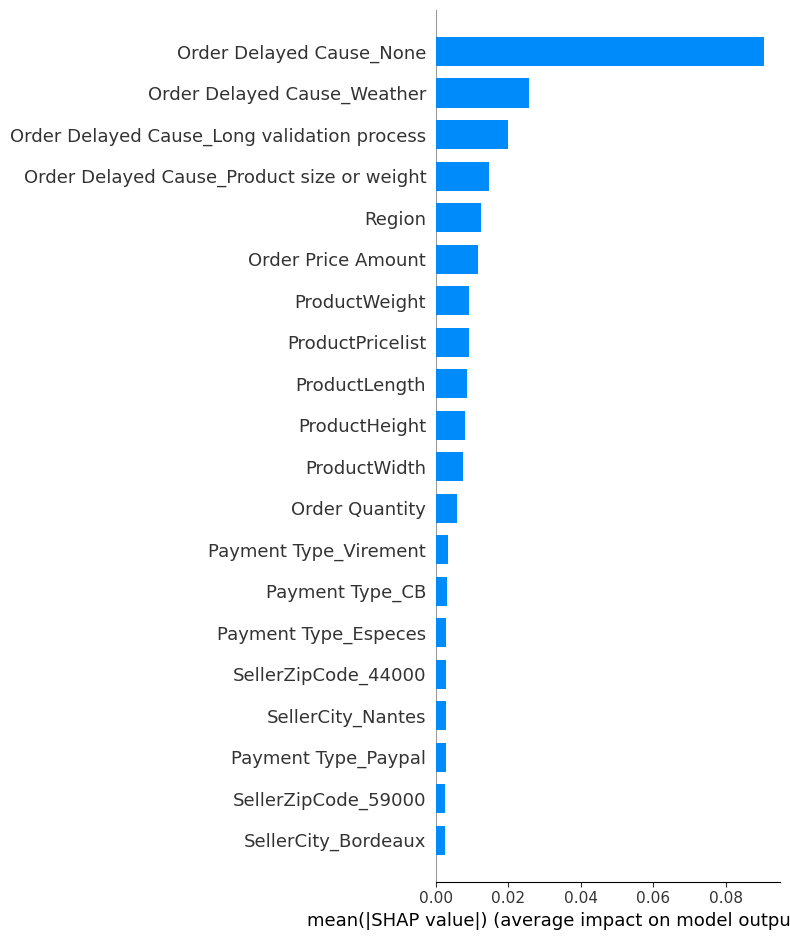

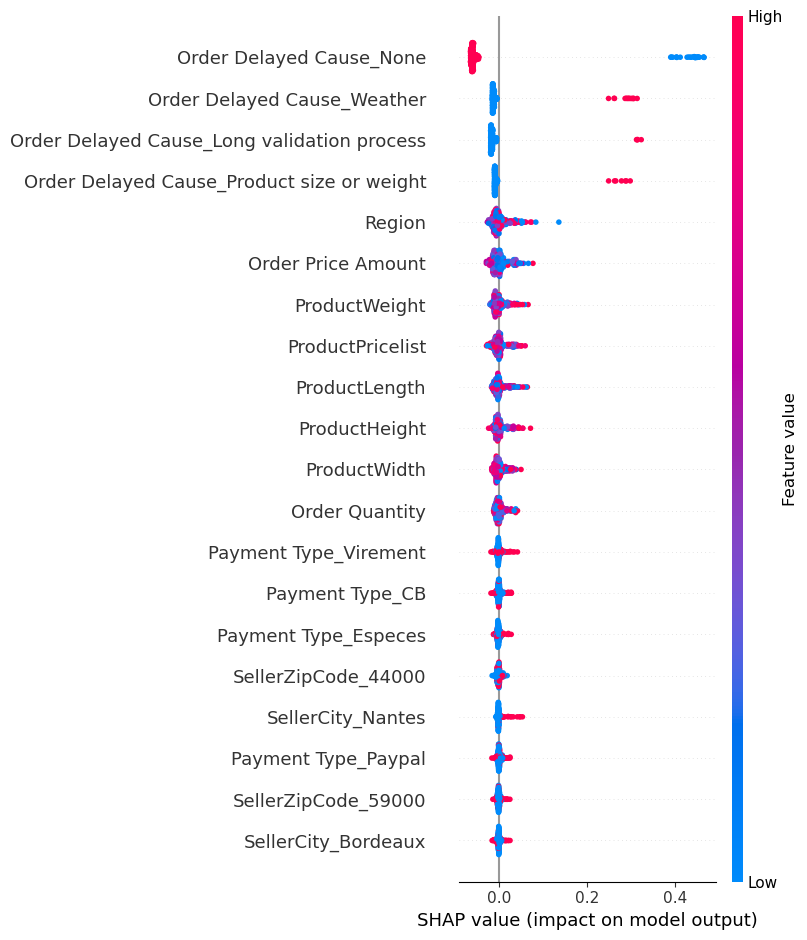

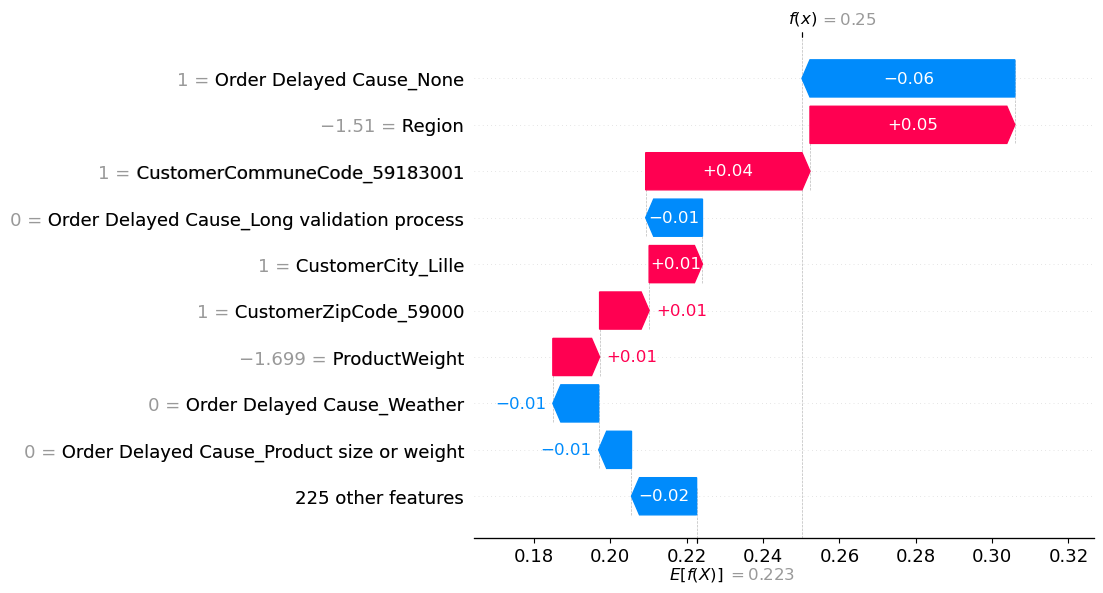

In [39]:
import shap

# Étape 1 : Transformation des données
X_train_sparse = pipeline.named_steps["preprocessor"].transform(X_train)
X_train_dense = X_train_sparse.toarray() if hasattr(X_train_sparse, "toarray") else X_train_sparse

# Étape 2 : Sélection des features utilisées par le modèle réduit
X_train_reduced = selector.transform(X_train_dense)

# Facultatif : noms des variables sélectionnées si besoin
selected_feature_names = [name for i, name in enumerate(all_feature_names) if selector.get_support()[i]]

# Étape 3 : Initialisation de l'explainer
explainer = shap.Explainer(model_reduced, X_train_reduced)

# Étape 4 : Calcul des valeurs SHAP (désactivation du check d’additivité ici)
shap_values = explainer(X_train_reduced[:300], check_additivity=False)

# Étape 5 : Visualisation globale des importances
shap.summary_plot(
    shap_values.values[:, :, 1],
    X_train_reduced[:300],
    feature_names=selected_feature_names,
    plot_type="bar"
)

# Étape 6 : Visualisation détaillée
shap.summary_plot(
    shap_values.values[:, :, 1],
    X_train_reduced[:300],
    feature_names=selected_feature_names
)

# Étape 7 : Waterfall plot pour une prédiction individuelle
instance_idx = 5
shap_single = shap.Explanation(
    values=shap_values.values[instance_idx, :, 1],
    base_values=shap_values.base_values[instance_idx, 1],
    data=X_train_reduced[instance_idx],
    feature_names=selected_feature_names
)
shap.plots.waterfall(shap_single, max_display=10)


In [40]:
import pickle
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# 1. Transformation + réduction de X_test
X_test_sparse = pipeline.named_steps["preprocessor"].transform(X_test)
X_test_dense = X_test_sparse.toarray() if hasattr(X_test_sparse, "toarray") else X_test_sparse
X_test_reduced = selector.transform(X_test_dense)

# 2. Prédictions finales
final_preds = model_reduced.predict(X_test_reduced)

# 3. Évaluation du modèle
print(" Évaluation finale du modèle réduit :")
print("Accuracy :", accuracy_score(y_test, final_preds))
print("F1 Score :", f1_score(y_test, final_preds))
print("\nMatrice de confusion :\n", confusion_matrix(y_test, final_preds))
print("\nRapport de classification :\n", classification_report(y_test, final_preds))

# 4. Sauvegarde du modèle réduit, pipeline et sélecteur avec pickle
with open("final_model_reduced.pkl", "wb") as f:
    pickle.dump(model_reduced, f)

with open("final_preprocessing_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

with open("final_feature_selector.pkl", "wb") as f:
    pickle.dump(selector, f)

print("\n Modèle réduit, pipeline et sélecteur sauvegardés avec succès.")


 Évaluation finale du modèle réduit :
Accuracy : 0.8498884885915251
F1 Score : 0.5338305807139051

Matrice de confusion :
 [[4453   11]
 [ 864  501]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.84      1.00      0.91      4464
           1       0.98      0.37      0.53      1365

    accuracy                           0.85      5829
   macro avg       0.91      0.68      0.72      5829
weighted avg       0.87      0.85      0.82      5829


 Modèle réduit, pipeline et sélecteur sauvegardés avec succès.
